# Yelp Exploration

In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import *
from sklearn import metrics

In [3]:
reviews = pd.read_csv('input/yelp_review.csv', nrows=10000)

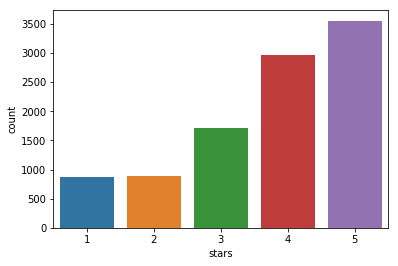

In [4]:
sns.countplot('stars', data=reviews)

In [5]:
train_data, dev_data, train_labels, dev_labels = \
    train_test_split(reviews.text.values, reviews.stars.values, test_size=.1, random_state=0)

## Count Vectorizer

In [6]:
cv = CountVectorizer(stop_words='english')
train_dtm = cv.fit_transform(train_data)
dev_dtm = cv.transform(dev_data)

lr = LogisticRegression()
lr.fit(train_dtm, train_labels)

print(metrics.classification_report(dev_labels, lr.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.69      0.63      0.66        94
          2       0.38      0.30      0.33        87
          3       0.38      0.30      0.34       175
          4       0.46      0.51      0.49       300
          5       0.61      0.66      0.64       344

avg / total       0.51      0.52      0.51      1000



In [7]:
len(cv.get_feature_names())

30044

## TFIDF Vectorizer

In [8]:
tv = TfidfVectorizer(stop_words='english')
train_dtm2 = tv.fit_transform(train_data)
dev_dtm2 = tv.transform(dev_data)

lr2 = LogisticRegression()
lr2.fit(train_dtm2, train_labels)

print(metrics.classification_report(dev_labels, lr2.predict(dev_dtm2)))

             precision    recall  f1-score   support

          1       0.77      0.54      0.64        94
          2       0.47      0.09      0.15        87
          3       0.47      0.29      0.36       175
          4       0.48      0.57      0.52       300
          5       0.59      0.78      0.68       344

avg / total       0.54      0.55      0.52      1000



## SVM

Interestingly, an SVM is horrible if we use the count vectorizer but on par with logistic regression if we use the tf-idf vectorizer.  Fitting is also much faster with tf-idf as well.

In [9]:
svc = LinearSVC()
svc.fit(train_dtm, train_labels)
print(metrics.classification_report(dev_labels, svc.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.68      0.55      0.61        94
          2       0.33      0.32      0.32        87
          3       0.35      0.32      0.34       175
          4       0.42      0.45      0.43       300
          5       0.59      0.62      0.60       344

avg / total       0.48      0.48      0.48      1000



In [10]:
svc2 = LinearSVC()
svc2.fit(train_dtm2, train_labels)
print(metrics.classification_report(dev_labels, svc2.predict(dev_dtm2)))

             precision    recall  f1-score   support

          1       0.68      0.65      0.66        94
          2       0.38      0.24      0.30        87
          3       0.38      0.33      0.35       175
          4       0.45      0.50      0.47       300
          5       0.62      0.68      0.65       344

avg / total       0.51      0.52      0.52      1000



## KNN

In [41]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_dtm, train_labels)
print(metrics.classification_report(dev_labels, knn.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.50      0.17      0.25        94
          2       0.21      0.05      0.08        87
          3       0.28      0.29      0.28       175
          4       0.33      0.29      0.31       300
          5       0.42      0.62      0.50       344

avg / total       0.36      0.37      0.34      1000



In [149]:
# Use GridSearchCV to optimize K with respect to weighted average f1
k = {'n_neighbors': [1, 3, 5, 7, 10, 20]}
knn = GridSearchCV(KNeighborsClassifier(), k, scoring = 'f1_weighted')
knn.fit(train_dtm, train_labels)
print("Best value of k is ", knn.best_params_)
print("Best score is", round(knn.best_score_,3))

Best value of k is  {'n_neighbors': 5}
Best score is 0.347


In [154]:
# Check impact of tuning k on f1 score for individual star ratings

k_test = [1,3,5,7,10,20]
results = []
for k in k_test:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_dtm, train_labels)
    scores = np.append(k, metrics.f1_score(dev_labels, knn.predict(dev_dtm), average = None))
    results.append(scores)

df = pd.DataFrame(results)
df.columns = ['k','1','2','3','4','5']
df.set_index('k')

,1,2,3,4,5
k,,,,,
1.0,0.201342,0.114754,0.256410,0.291115,0.482490
3.0,0.284264,0.139860,0.272941,0.251101,0.499360
5.0,0.253968,0.075472,0.283286,0.305506,0.502347
7.0,0.240000,0.056604,0.261818,0.319109,0.534031
10.0,0.165138,0.020833,0.208000,0.302583,0.536391
20.0,0.061224,0.064516,0.131313,0.305284,0.541818


Increasing k generally reduces f1 score for low ratings (1 to 3 stars) while increasing it for 5 start reviews. Since there are more 5 star reviews than any other, this may indicate that with high k we start underfitting and predict 5's.

Try KNN using tf-idf vectorizer

In [39]:
knn2 = KNeighborsClassifier(n_neighbors=5)
knn2.fit(train_dtm2, train_labels)
print(metrics.classification_report(dev_labels, knn2.predict(dev_dtm)))

             precision    recall  f1-score   support

          1       0.49      0.39      0.44        94
          2       0.25      0.13      0.17        87
          3       0.25      0.34      0.29       175
          4       0.36      0.39      0.37       300
          5       0.53      0.51      0.52       344

avg / total       0.40      0.40      0.40      1000

